In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D, LSTM, SimpleRNN, LSTMCell, Activation

np.set_printoptions(edgeitems=np.inf)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess);

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [11]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]

In [12]:
def gen_data(n, seq_len, pred_len, dim):
    data = np.zeros(shape=(n, seq_len + pred_len, dim))
    
    for i in range(n):
        val = []
        for d in range(dim):
            x = np.arange(0, (seq_len + pred_len) / 10, 0.1)
            flag = np.random.randint(0, 3)
            if flag == 0:
                y = np.sin(x)
            elif flag == 1:
                y = np.cos(x)
            elif flag == 2:
                y = np.sin(x) * np.cos(x)
            var1 = np.random.uniform(0, 1, (seq_len + pred_len))
            var2 = np.random.uniform(0, 1, (seq_len + pred_len))
            var = var1 * var2
            y = (np.e * (y**2)) / (np.power(0.4, y) + 1e-3) * var
            val.append(y)        
        data[i] = np.asarray(val).T
     
    X = data[:, :seq_len]
    Y = data[:, seq_len:]
                   
    return X, Y

In [13]:
n_epochs = 500
batch_size = 16
lr = 1e-4
n = 2500
n_train = int(n * 0.6)
seq_len = 300
pred_len = 30
dim = 4
n_pred = 3
n_tests = 1

X, Y = gen_data(n, seq_len, pred_len, dim)
x0 = X[:n_train]
y0 = Y[:n_train]
x2 = X[n_train:]
y2 = Y[n_train:]

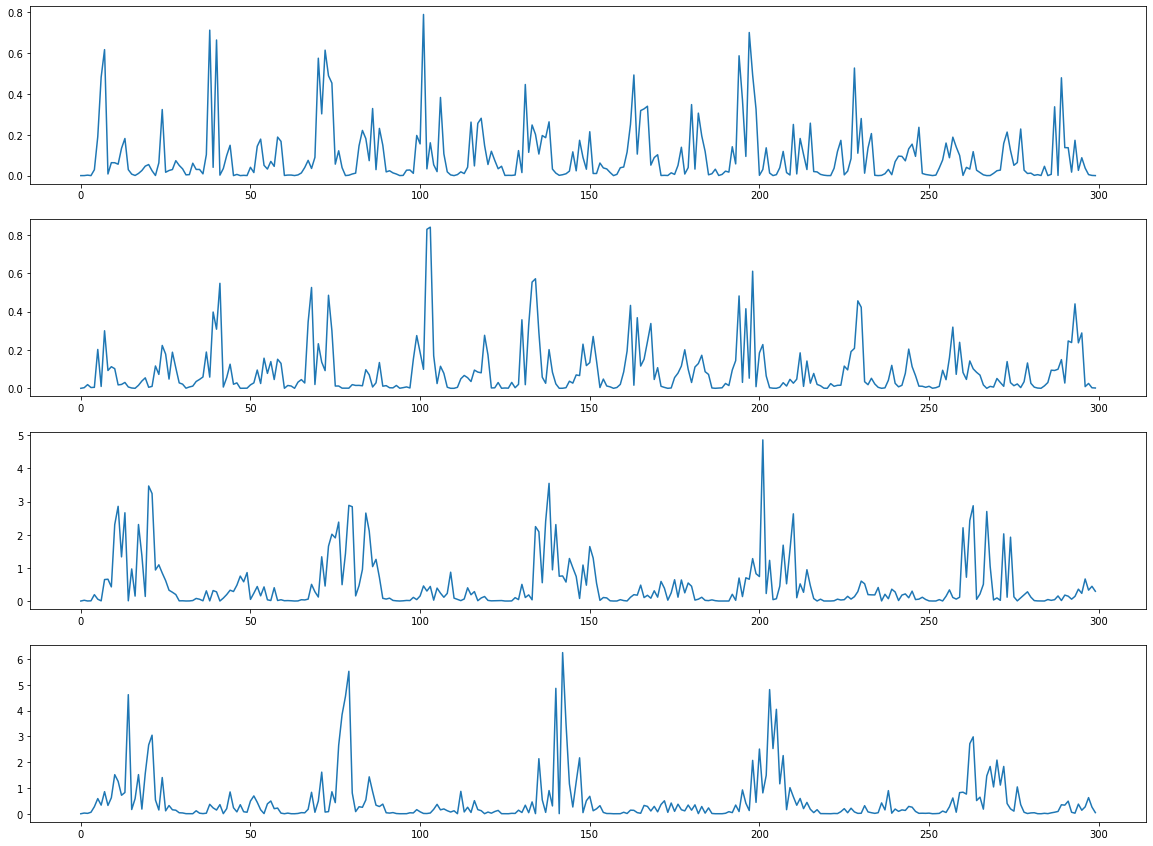

In [14]:
fig, axes = plt.subplots(nrows=dim, ncols=1, figsize=(20, 15))
for i in range(dim):
    axes[i].plot(np.arange(0, seq_len), X[0, :, i])

In [15]:
model = Sequential()
model.add(Convolution1D(12, kernel_size=9, strides=1, batch_input_shape=(None, None, dim), padding='causal'))
model.add(Convolution1D(24, kernel_size=7, strides=1, padding='causal', dilation_rate= 2))
model.add(Convolution1D(12, kernel_size=5, strides=1, padding='causal', dilation_rate= 4))
model.add(Convolution1D(24, kernel_size=3, strides=1, padding='causal', dilation_rate= 6))
model.add(Convolution1D(12, kernel_size=3, strides=1, padding='causal', dilation_rate= 8))
model.add(Convolution1D(24, kernel_size=3, strides=1, padding='causal', dilation_rate=10))
model.add(Convolution1D(12, kernel_size=5, strides=1, padding='causal', dilation_rate=15))
model.add(Convolution1D(24, kernel_size=7, strides=1, padding='causal', dilation_rate=30))
model.add(Convolution1D(12, kernel_size=9, strides=1, padding='causal', dilation_rate=60))
model.add(Dense(dim**3))
model.add(Dense(dim**2))
model.add(Dense(dim))
model.add(Activation("softmax"))
model.add(Lambda(slice, arguments={'slice_length':pred_len}))
model.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
model.summary();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 12)          444       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 24)          2040      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 36)          4356      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 48)          5232      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 60)          8700      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 72)          13032     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 84)         

In [16]:
history = model.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 1500 samples, validate on 1000 samples
Epoch 1/500
1500/1500 [==============================] - 4s 3ms/sample - loss: 0.5991 - mse: 0.5991 - val_loss: 0.5813 - val_mse: 0.5813
Epoch 2/500
1500/1500 [==============================] - 1s 757us/sample - loss: 0.5873 - mse: 0.5873 - val_loss: 0.5736 - val_mse: 0.5736
Epoch 3/500
1500/1500 [==============================] - 1s 783us/sample - loss: 0.5838 - mse: 0.5838 - val_loss: 0.5781 - val_mse: 0.5781
Epoch 4/500
1500/1500 [==============================] - 1s 736us/sample - loss: 0.5826 - mse: 0.5826 - val_loss: 0.5786 - val_mse: 0.5786
Epoch 5/500
1500/1500 [==============================] - 1s 861us/sample - loss: 0.5827 - mse: 0.5827 - val_loss: 0.5762 - val_mse: 0.5762
Epoch 6/500
1500/1500 [==============================] - 1s 816us/sample - loss: 0.5816 - mse: 0.5816 - val_loss: 0.5741 - val_mse: 0.5741
Epoch 7/500
1500/1500 [==============================] - 1s 868us/sample - loss: 0.5813 - mse: 0.5813 - val_loss: 0.5782

1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5734 - mse: 0.5734 - val_loss: 0.5785 - val_mse: 0.5785
Epoch 60/500
1500/1500 [==============================] - 1s 792us/sample - loss: 0.5733 - mse: 0.5733 - val_loss: 0.5776 - val_mse: 0.5776
Epoch 61/500
1500/1500 [==============================] - 1s 852us/sample - loss: 0.5725 - mse: 0.5725 - val_loss: 0.5788 - val_mse: 0.5788
Epoch 62/500
1500/1500 [==============================] - 1s 803us/sample - loss: 0.5726 - mse: 0.5726 - val_loss: 0.5775 - val_mse: 0.5775
Epoch 63/500
1500/1500 [==============================] - 1s 924us/sample - loss: 0.5733 - mse: 0.5733 - val_loss: 0.5760 - val_mse: 0.5760
Epoch 64/500
1500/1500 [==============================] - 1s 901us/sample - loss: 0.5729 - mse: 0.5729 - val_loss: 0.5769 - val_mse: 0.5769
Epoch 65/500
1500/1500 [==============================] - 1s 836us/sample - loss: 0.5732 - mse: 0.5732 - val_loss: 0.5778 - val_mse: 0.5778
Epoch 66/500
1500/1500 [===========

1500/1500 [==============================] - 1s 860us/sample - loss: 0.5721 - mse: 0.5721 - val_loss: 0.5781 - val_mse: 0.5781
Epoch 118/500
1500/1500 [==============================] - 1s 856us/sample - loss: 0.5719 - mse: 0.5719 - val_loss: 0.5762 - val_mse: 0.5762
Epoch 119/500
1500/1500 [==============================] - 1s 905us/sample - loss: 0.5708 - mse: 0.5708 - val_loss: 0.5769 - val_mse: 0.5769
Epoch 120/500
1500/1500 [==============================] - 1s 820us/sample - loss: 0.5710 - mse: 0.5710 - val_loss: 0.5769 - val_mse: 0.5769
Epoch 121/500
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5711 - mse: 0.5711 - val_loss: 0.5763 - val_mse: 0.5763
Epoch 122/500
1500/1500 [==============================] - 1s 822us/sample - loss: 0.5713 - mse: 0.5713 - val_loss: 0.5784 - val_mse: 0.5784
Epoch 123/500
1500/1500 [==============================] - 1s 793us/sample - loss: 0.5722 - mse: 0.5722 - val_loss: 0.5768 - val_mse: 0.5768
Epoch 124/500
1500/1500 [====

1500/1500 [==============================] - 1s 872us/sample - loss: 0.5710 - mse: 0.5710 - val_loss: 0.5770 - val_mse: 0.5770
Epoch 176/500
1500/1500 [==============================] - 1s 814us/sample - loss: 0.5712 - mse: 0.5712 - val_loss: 0.5767 - val_mse: 0.5767
Epoch 177/500
1500/1500 [==============================] - 1s 830us/sample - loss: 0.5706 - mse: 0.5706 - val_loss: 0.5767 - val_mse: 0.5767
Epoch 178/500
1500/1500 [==============================] - 1s 826us/sample - loss: 0.5702 - mse: 0.5702 - val_loss: 0.5777 - val_mse: 0.5777
Epoch 179/500
1500/1500 [==============================] - 1s 813us/sample - loss: 0.5707 - mse: 0.5707 - val_loss: 0.5764 - val_mse: 0.5764
Epoch 180/500
1500/1500 [==============================] - 1s 871us/sample - loss: 0.5704 - mse: 0.5704 - val_loss: 0.5767 - val_mse: 0.5767
Epoch 181/500
1500/1500 [==============================] - 1s 857us/sample - loss: 0.5707 - mse: 0.5707 - val_loss: 0.5767 - val_mse: 0.5767
Epoch 182/500
1500/1500 [==

1500/1500 [==============================] - 1s 818us/sample - loss: 0.5707 - mse: 0.5707 - val_loss: 0.5783 - val_mse: 0.5783
Epoch 234/500
1500/1500 [==============================] - 1s 850us/sample - loss: 0.5700 - mse: 0.5700 - val_loss: 0.5779 - val_mse: 0.5779
Epoch 235/500
1500/1500 [==============================] - 1s 832us/sample - loss: 0.5704 - mse: 0.5704 - val_loss: 0.5769 - val_mse: 0.5769
Epoch 236/500
1500/1500 [==============================] - 1s 774us/sample - loss: 0.5704 - mse: 0.5704 - val_loss: 0.5767 - val_mse: 0.5767
Epoch 237/500
1500/1500 [==============================] - 1s 785us/sample - loss: 0.5699 - mse: 0.5699 - val_loss: 0.5761 - val_mse: 0.5761
Epoch 238/500
1500/1500 [==============================] - 1s 827us/sample - loss: 0.5699 - mse: 0.5699 - val_loss: 0.5778 - val_mse: 0.5778
Epoch 239/500
1500/1500 [==============================] - 1s 837us/sample - loss: 0.5702 - mse: 0.5702 - val_loss: 0.5776 - val_mse: 0.5776
Epoch 240/500
1500/1500 [==

1500/1500 [==============================] - 1s 764us/sample - loss: 0.5697 - mse: 0.5697 - val_loss: 0.5771 - val_mse: 0.5771
Epoch 292/500
1500/1500 [==============================] - 1s 790us/sample - loss: 0.5696 - mse: 0.5696 - val_loss: 0.5781 - val_mse: 0.5781
Epoch 293/500
1500/1500 [==============================] - 1s 798us/sample - loss: 0.5695 - mse: 0.5695 - val_loss: 0.5772 - val_mse: 0.5772
Epoch 294/500
1500/1500 [==============================] - 1s 769us/sample - loss: 0.5699 - mse: 0.5699 - val_loss: 0.5777 - val_mse: 0.5777
Epoch 295/500
1500/1500 [==============================] - 1s 786us/sample - loss: 0.5694 - mse: 0.5694 - val_loss: 0.5767 - val_mse: 0.5767
Epoch 296/500
1500/1500 [==============================] - 1s 853us/sample - loss: 0.5696 - mse: 0.5696 - val_loss: 0.5769 - val_mse: 0.5769
Epoch 297/500
1500/1500 [==============================] - 1s 814us/sample - loss: 0.5696 - mse: 0.5696 - val_loss: 0.5767 - val_mse: 0.5767
Epoch 298/500
1500/1500 [==

1500/1500 [==============================] - 1s 754us/sample - loss: 0.5690 - mse: 0.5690 - val_loss: 0.5763 - val_mse: 0.5763
Epoch 350/500
1500/1500 [==============================] - 1s 775us/sample - loss: 0.5695 - mse: 0.5695 - val_loss: 0.5783 - val_mse: 0.5783
Epoch 351/500
1500/1500 [==============================] - 1s 875us/sample - loss: 0.5690 - mse: 0.5690 - val_loss: 0.5783 - val_mse: 0.5783
Epoch 352/500
1500/1500 [==============================] - 1s 830us/sample - loss: 0.5692 - mse: 0.5692 - val_loss: 0.5769 - val_mse: 0.5769
Epoch 353/500
1500/1500 [==============================] - 1s 873us/sample - loss: 0.5687 - mse: 0.5687 - val_loss: 0.5786 - val_mse: 0.5786
Epoch 354/500
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5691 - mse: 0.5691 - val_loss: 0.5771 - val_mse: 0.5771
Epoch 355/500
1500/1500 [==============================] - 1s 921us/sample - loss: 0.5697 - mse: 0.5697 - val_loss: 0.5766 - val_mse: 0.5766
Epoch 356/500
1500/1500 [====

1500/1500 [==============================] - 1s 824us/sample - loss: 0.5689 - mse: 0.5689 - val_loss: 0.5765 - val_mse: 0.5765
Epoch 408/500
1500/1500 [==============================] - 1s 770us/sample - loss: 0.5688 - mse: 0.5688 - val_loss: 0.5778 - val_mse: 0.5778
Epoch 409/500
1500/1500 [==============================] - 1s 821us/sample - loss: 0.5684 - mse: 0.5684 - val_loss: 0.5767 - val_mse: 0.5767
Epoch 410/500
1500/1500 [==============================] - 1s 793us/sample - loss: 0.5688 - mse: 0.5688 - val_loss: 0.5779 - val_mse: 0.5779
Epoch 411/500
1500/1500 [==============================] - 1s 818us/sample - loss: 0.5693 - mse: 0.5693 - val_loss: 0.5790 - val_mse: 0.5790
Epoch 412/500
1500/1500 [==============================] - 1s 977us/sample - loss: 0.5692 - mse: 0.5692 - val_loss: 0.5781 - val_mse: 0.5781
Epoch 413/500
1500/1500 [==============================] - 1s 859us/sample - loss: 0.5688 - mse: 0.5688 - val_loss: 0.5791 - val_mse: 0.5791
Epoch 414/500
1500/1500 [==

1500/1500 [==============================] - 1s 873us/sample - loss: 0.5689 - mse: 0.5689 - val_loss: 0.5775 - val_mse: 0.5775
Epoch 466/500
1500/1500 [==============================] - 1s 899us/sample - loss: 0.5685 - mse: 0.5685 - val_loss: 0.5778 - val_mse: 0.5778
Epoch 467/500
1500/1500 [==============================] - 1s 864us/sample - loss: 0.5682 - mse: 0.5682 - val_loss: 0.5773 - val_mse: 0.5773
Epoch 468/500
1500/1500 [==============================] - 1s 790us/sample - loss: 0.5684 - mse: 0.5684 - val_loss: 0.5772 - val_mse: 0.5772
Epoch 469/500
1500/1500 [==============================] - 1s 792us/sample - loss: 0.5682 - mse: 0.5682 - val_loss: 0.5777 - val_mse: 0.5777
Epoch 470/500
1500/1500 [==============================] - 1s 788us/sample - loss: 0.5684 - mse: 0.5684 - val_loss: 0.5774 - val_mse: 0.5774
Epoch 471/500
1500/1500 [==============================] - 1s 786us/sample - loss: 0.5688 - mse: 0.5688 - val_loss: 0.5773 - val_mse: 0.5773
Epoch 472/500
1500/1500 [==

Train MSE: 0.5649988551139832
Validate MSE: 0.5767388978004455


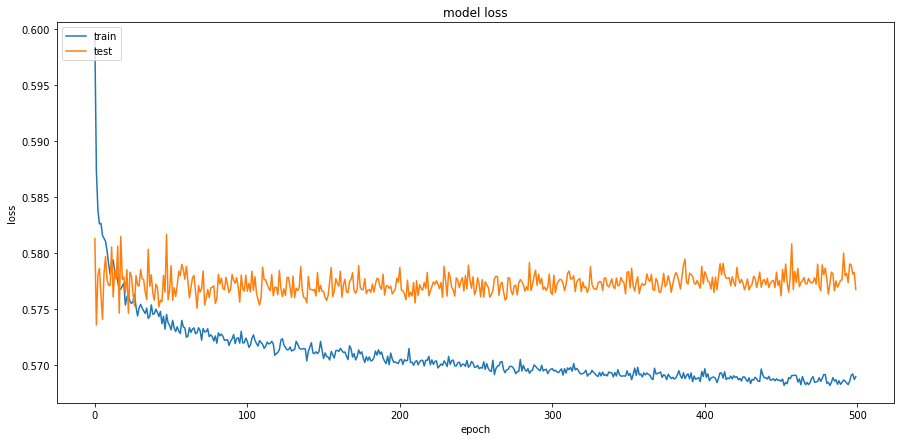

In [17]:
score_train = model.evaluate(x0, y0, verbose=0)
score_val = model.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

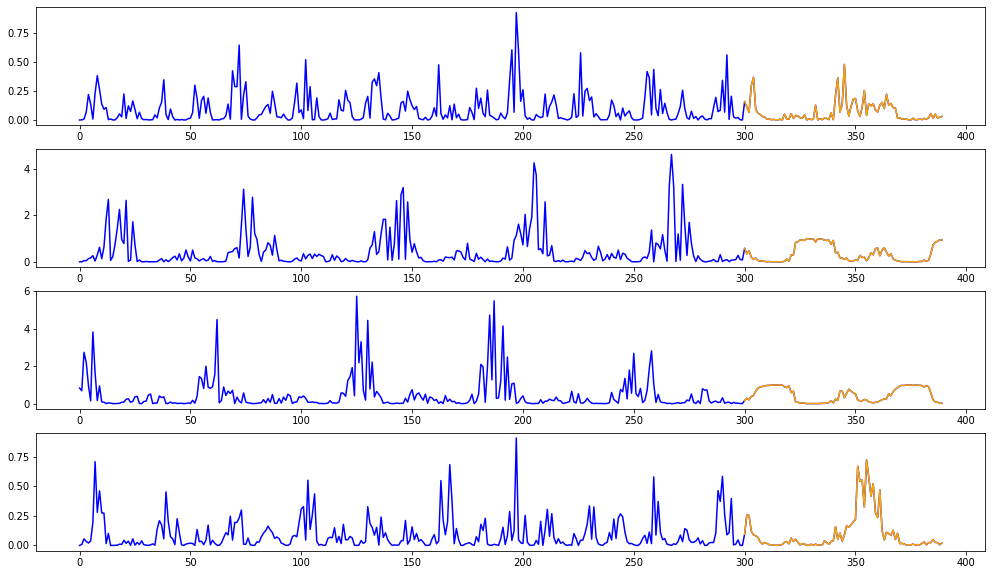

In [18]:
x_test, y_test = gen_data(n_tests, seq_len, pred_len, dim)
for i in range(n_pred):
    y = model.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, seq_len:]

fig, axes = plt.subplots(nrows=dim, ncols=1, figsize=(17, 10))
for i in range(dim):
    axes[i].plot(range(0, seq_len + (n_pred * pred_len)), x_test[0, :, i],'b-')
    axes[i].plot(range(seq_len, seq_len + (n_pred * pred_len)), y_pred[0, :, i],'b-', color='orange')